% 这个脚本建于已经read并write了所有temp和precip数据的R脚本之后，直接读取所有（100y）的模型输出数据。这一步可以被更改。
# 添加必要package

In [1]:
#%autoreload

import pandas as pd
import numpy as np
import netCDF4 as nc
# some user defined functions
import GP_P as GP_P
import compute_covariance as cov_matrix

### defined forcing data path in the prediction/run.ipynb

# Read emulator 
read the sum of 5 parameters in calibration to normalize the new input
read the GP list from calibration 
read the PCA from calibration

In [45]:
import netCDF4 as nc
import h5py

# Open the 5 variables sum for standardization
#################################################
nc_data = nc.Dataset("emul_input_5variables_sum.nc")
var_names = list(nc_data.variables.keys())
for var_name in var_names:
    globals()[var_name] = nc_data.variables[var_name][:]
    print(var_name)


# define a function to read the h5 data recursively into a dictionary
#----------------------------------------------------------------------
def load_h5_as_dict(h5_group):
    data = {}
    for key, item in h5_group.items():
        if isinstance(item, h5py.Group):
            # If the item is a group, recurse into it
            data[key] = load_h5_as_dict(item)
        elif isinstance(item, h5py.Dataset):
            # If the item is a dataset, load it as a NumPy array
            data[key] = np.array(item)
    
    # Load attributes as well, if any
    for attr_key, attr_value in h5_group.attrs.items():
        data[attr_key] = attr_value  # Store attributes as dictionary entries

    return data
#--------------------------------------------------------------------
# Load the HDF5 file and convert it into a dictionary
#######################################################
with h5py.File("GPList.h5", "r") as GPList:
    EM_Cali = load_h5_as_dict(GPList)
print('keys of EM_Cali are:',EM_Cali.keys())
print('for each month in EM_Cali, the keys are:',EM_Cali['month_01'].keys())
print('for each PC in EM_Cali, the keys are:',EM_Cali['month_01']['PC_01'].keys())

# Check if the regression type is not linear
if EM_Cali['month_01']['PC_01']['regress'] != 'linear':
    raise ValueError("The regression type is not linear. Please check the Clibration.ipynb and add the corresponding callable function.")


nkeep = len(EM_Cali.keys()) # number of PCAs

# Load the PCA components 
##########################
with h5py.File("PCA_temp.h5", "r") as PCA:
    PCs = load_h5_as_dict(PCA)
print('keys of PCS are:',PCs.keys())
print('for each month in PCs, the keys are:',PCs['month_01'].keys())


esinw_sum
ecosw_sum
obliquity_sum
co2_sum
ice_sum
keys of EM_Cali are: dict_keys(['month_01', 'month_02', 'month_03', 'month_04', 'month_05', 'month_06', 'month_07', 'month_08', 'month_09', 'month_10', 'month_11', 'month_12'])
for each month in EM_Cali, the keys are: dict_keys(['PC_01', 'PC_02', 'PC_03', 'PC_04', 'PC_05', 'PC_06', 'PC_07', 'PC_08', 'PC_09', 'PC_10', 'PC_11', 'PC_12', 'PC_13', 'PC_14', 'PC_15', 'PC_16', 'PC_17', 'PC_18', 'PC_19', 'PC_20'])
for each PC in EM_Cali, the keys are: dict_keys(['R', 'R1tX', 'Rt', 'X', 'Y', 'betahat', 'e', 'log_REML', 'log_pen_REML', 'muX', 'sigma_hat_2', 'covar', 'funcmu', 'lambda', 'nbrr', 'regress'])
keys of PCS are: dict_keys(['month_01', 'month_02', 'month_03', 'month_04', 'month_05', 'month_06', 'month_07', 'month_08', 'month_09', 'month_10', 'month_11', 'month_12'])
for each month in PCs, the keys are: dict_keys(['PCA', 'amps', 'd', 'mean', 'rvm', 'scaled_amps'])


# Read Input Data for Prediction
read the new 5 parameters: orbital parameters, CO2 and ice sheet parameter

In [25]:

# Read the input data (orbital parameters and CO2 values) contains the values across all years
x_full = pd.read_csv('emul_input.txt', sep='\s+', header=None)  # Read table
# Read the input data: ice sheet parameter (ice volume)
x_vol = np.loadtxt('emulice_full_dt1000.txt')  # Read as a numpy array

##### Modify needed, there only read one year data, so can do a loop to get all year data
##### Here the first 0 is the 0th year, can be changed.
##### For x_vol, put the year you want to predict in the first place. This can be further modified.
index = int(x_vol[0, 0]) # Index of the year to extract variables from x_full (convert to integer for indexing)
x_ice = x_vol[0,1]       # Ice volume as the second value

# Extract the proper year, 
# Note: need to be minus one due to the 0-based index, which is different from R
x_year = x_full.iloc[index-1, :]  # Extract the row corresponding to the year

# Normalize input variables
var1 = x_year[0] / esinw_sum        # Normalize `V1` by `esinw_sum`
var2 = x_year[1] / ecosw_sum        # Normalize `V2` by `ecosw_sum`
var3 = x_year[2] / obliquity_sum    # Normalize `V3` by `obliquity_sum`
var4 = x_year[3] / co2_sum          # Normalize `V4` by `co2_sum`
var5 = x_ice / ice_sum              # Normalize ice volume by `ice_sum`


# make vector of all input variables at the current year
x = np.array([var1, var2, var3, var4, var5])

print("the 5 input variable for prediction are:",x)


the 5 input variable for prediction are: [-0.38587849  0.04296161  0.01025098  0.01202713  0.00085885]


## Visulisaztion of the input data to help understanding 

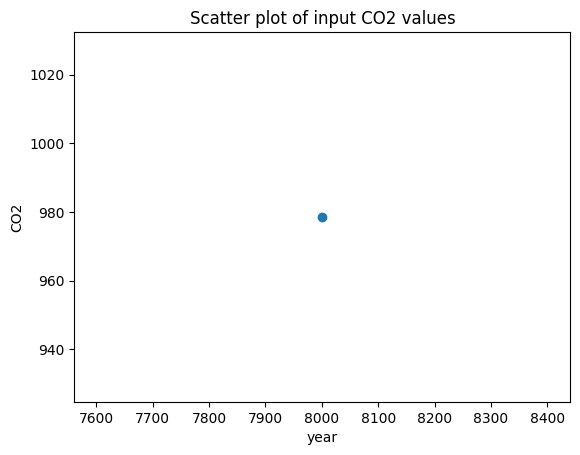

In [4]:
array_length = np.arange(len(x_full.iloc[:,0]))

import matplotlib.pyplot as plt

plt.scatter(index, x_year[3])
plt.xlabel('year')
plt.ylabel('CO2')
plt.title('Scatter plot of input CO2 values')
plt.show()


# Prediction

In [5]:
### test code
#i=0
#for key, PC in EM_Cali.items():
#    print('for PC',i,' the keys are',PC.keys())
#    i+=1
#    print('shape of PC:',PC['X'].shape)
print('There are',len(EM_Cali),' PCs, an example: ')
print('for PC1 the keys are',EM_Cali['PC_1'].keys())



There are 20  PCs, an example: 
for PC1 the keys are dict_keys(['R', 'R1tX', 'Rt', 'X', 'Y', 'betahat', 'e', 'log_REML', 'log_pen_REML', 'muX', 'sigma_hat_2', 'covar', 'funcmu', 'lambda', 'nbrr', 'regress'])


In [53]:
# estimate the current climate using the PCA routine pe_p 
%reload_ext autoreload
%autoreload 2

temperature = {}
for month in range(1, 13):
    month_key = f'month_{month:02d}'
    temperature[month_key] = GP_P.GP_P(EM_Cali[month_key], PCs[month_key], x)

for i, (key, PC) in enumerate(temperature.items()):
    print(f'for key {key}, the sub key is {PC.keys()}')
# the mean temperature field for each month is:
#temp_jan = temperature[0]['mean'] - 273.15
#temp_dec = temperature[11]['mean'] - 273.15

# create an array on the ice sheet model grid of the form (LAT, LON) : 
yval = 201
xval = 201
nmonths = 12

OUTPUT_TEMP = np.zeros((yval, xval, nmonths))
AVG_TEMP = np.zeros((nmonths))

for imonth in range(12):
    month_key = f'month_{imonth+1:02d}'
    OUTPUT_TEMP[:, :, imonth] = temperature[month_key]['mean'] - 273.15

print('shape of OUTPUT_TEMP:',OUTPUT_TEMP.shape)

for key month_01, the sub key is dict_keys(['mean', 'var', 'means', 'variances'])
for key month_02, the sub key is dict_keys(['mean', 'var', 'means', 'variances'])
for key month_03, the sub key is dict_keys(['mean', 'var', 'means', 'variances'])
for key month_04, the sub key is dict_keys(['mean', 'var', 'means', 'variances'])
for key month_05, the sub key is dict_keys(['mean', 'var', 'means', 'variances'])
for key month_06, the sub key is dict_keys(['mean', 'var', 'means', 'variances'])
for key month_07, the sub key is dict_keys(['mean', 'var', 'means', 'variances'])
for key month_08, the sub key is dict_keys(['mean', 'var', 'means', 'variances'])
for key month_09, the sub key is dict_keys(['mean', 'var', 'means', 'variances'])
for key month_10, the sub key is dict_keys(['mean', 'var', 'means', 'variances'])
for key month_11, the sub key is dict_keys(['mean', 'var', 'means', 'variances'])
for key month_12, the sub key is dict_keys(['mean', 'var', 'means', 'variances'])
shape of OUTPUT_

# Write the results into NetCDF

In [ ]:
import os


#----------------------------------------------------------------------------------------------------
# write temperature to NetCDF file
#----------------------------------------------------------------------------------------------------
name="TEMP_predict"
format=".nc"

# Check if the NetCDF file already exists, if so, overwrite it
if os.path.exists(f"{name}{format}"):
    os.remove(f"{name}{format}")

ncnew = nc.Dataset(f"{name}{format}", "w")

lat    = np.arange(1, 202)
lon    = np.arange(1, 202)
months = np.arange(1, 13)

# Define dimensions
ncnew.createDimension("lon", len(lon))
ncnew.createDimension("lat", len(lat))
ncnew.createDimension("months", len(months))

# Define variables
temp_all = ncnew.createVariable("temperature", "f4", ("lon", "lat", "months"))
temp_all.units = "Celsius"
temp_all.long_name = "Predicted Temperature"

# Define coordinate variables
latitudes = ncnew.createVariable("latitude", "f4", ("lat",))
longitudes = ncnew.createVariable("longitude", "f4", ("lon",))
time = ncnew.createVariable("month", "i4", ("months",))

# Assign attributes to coordinate variables
latitudes.units = "degrees_north"
latitudes.long_name = "Latitude"
longitudes.units = "degrees_east"
longitudes.long_name = "Longitude"
time.units = "months"
time.long_name = "Time"

# Write data to coordinate variables
latitudes[:] = lat
longitudes[:] = lon
time[:] = months

# Write data to variables
temp_all[:, :, :] = OUTPUT_TEMP

# Close the NetCDF file
ncnew.close()